# File benchs.py
This contains the code used to create the plots of presentations and report about the fast inference of Forests (BDT in particular)
#### Usage
Create the folder `./tmp/`, then run 
```bash
$ python bench.py
```
You can also easily tune which benchmarks you want/add more by understanding the function execute bench that can be used as:
```python
# set some fixed falues for all benchs
STD_NUM_SAMPLES = 100_000
STD_NUM_FEATURES = 5
STD_DEPTH = 3
STD_NUM_TREES = 200

# define what is constant through this benchmark
timeVSdepth = dict(
    num_samples=STD_NUM_SAMPLES,
    num_features=STD_NUM_FEATURES,
    num_trees=STD_NUM_TREES,
    data_folder=DATA_FOLDER,
    save_models=True,
)

# execute bench for a range of values. 
# Repeat the same command for other ranges & varying other values
execute_bench(
        "./tmp/timeVSmiddleEvents/",
        [1000, 5000, 10000],
        1,  # repetitions
        "num_samples",
        timeVSevents,
    )
```


In [1]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_tree
import matplotlib.pyplot as plt
import xgboost as xgb
import timeit

import subprocess

from bench import *
from utils import *

import json # for testing jsonness
import numpy as np
from os import listdir
from os.path import isfile, join

### Tests

In [2]:
FIG_FOLDER = "./figures/"
TMP_FOLDER = "tmp/"

In [3]:
if not os.path.exists(FIG_FOLDER):
    os.makedirs(FIG_FOLDER)

In [4]:
INFOS = [ 
    ("branched",                ":+", "cyan"), 
    ("branchless",              ":+", "orange"),
    ("branchless_unordered",    ":<", "orange"),
    ("branchedJIT",             ":+", "blue"), 
    ("branchlessJIT",           ":+", "red"),
    ("branchlessJIT_unordered", ":<", "red"), 
    ("branched_Batch",          "--.", "cyan"), 
    ("branchless_Batch",        "--.", "orange"), 
    ("branchedJIT_Batch",       "--.", "blue"), 
    ("branchlessJIT_Batch",     "--.", "red"),
    ("xgb", "-+","k")
]

LABELS = [x[0] for x in INFOS]
STYLES = [x[1] for x in INFOS]
COLORS = [x[2] for x in INFOS]
#ALPHAS = [x[3] for x in INFOS]

In [5]:
def plot_labels(data_dict, bench_name, fig_folder, labels=LABELS, is_xlog=False, is_ylog=False, 
                x_units=" [-]", y_units=" [ms]", scaled=False, fname_postfix="", with_error_bars=False, indices=[],
                styles=STYLES, colors=COLORS):
    fig=plt.figure()
    for i, label in enumerate(labels):
        if indices:
            if i not in indices:
                continue
        to_plot = data_dict["mins"][:,i]
        if scaled is True:
            to_plot = to_plot/data_dict["abscisse"]
        if with_error_bars is True:
            plt.errorbar(data_dict["abscisse"], to_plot, data_dict["stds"][:,i], linestyle='--', marker='^', label=label)
        else:
            plt.plot(data_dict["abscisse"], to_plot, styles[i], color=colors[i], label=label )
        
    bench_name.find("VS")
    y_label = bench_name[:bench_name.find("VS")]
    x_label = bench_name[bench_name.find("VS")+2:]
    
    if scaled is True:
        y_label = y_label+"/"+x_label
    plt.xlabel(x_label+x_units)
    plt.ylabel(y_label+y_units)
    
    plt.grid()
    
    if is_xlog:
        plt.xscale('log')
    if is_ylog:
        plt.yscale('log')
    lgd = plt.legend(bbox_to_anchor=(1, 1));
    fig.subplots_adjust(left=0.2)
    plt.show()
    fig.savefig(fig_folder+bench_name+fname_postfix+".pdf", format="pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [6]:
def get_values_from_bench(path_to_files):
    onlyfiles = sorted([f for f in listdir(path_to_files) if isfile(join(path_to_files, f))])
    print(f"Files: {onlyfiles}")
    
    
    
    min_values = []
    std_values = []
    for file in onlyfiles:
        if file[0:3] == "std":
            std_values.append(file)
        elif file[0:3] == "0_a":
            continue
        else:
            min_values.append(file)
     
    mins_list = []
    for f in min_values:
        mins_list.append(np.load(path_to_files+f))
    mins_array = np.array(mins_list)
    
    
    stds_list = []
    for f in std_values:
        stds_list.append(np.load(path_to_files+f))
    stds = np.array(stds_list)
    
    abscisse=np.load(path_to_files+"0_abscisse.npy")
    abscisse = abscisse[:]
    
    
    
    print(f"Abscisse shape: {abscisse.shape}")
    print(f"Mins shape: {mins_array.shape}")
    print(f"Std_dev: {stds.shape}")
    
    return dict(abscisse=abscisse, mins=mins_array, stds=stds)
    

## timeVSdepth

Files: ['0_abscisse.npy', 'min_000_.npy', 'min_001_.npy', 'min_002_.npy', 'min_003_.npy', 'std_000_.npy', 'std_001_.npy', 'std_002_.npy', 'std_003_.npy']
Abscisse shape: (4,)
Mins shape: (4, 11)
Std_dev: (4, 11)


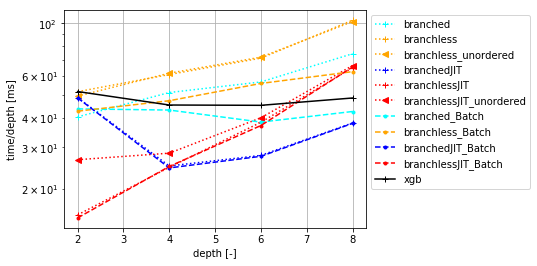

In [26]:
bench_name = "timeVSdepth"

mypath="./"+TMP_FOLDER+bench_name+"/"

data_dict = get_values_from_bench(mypath)


plot_labels(data_dict, bench_name, FIG_FOLDER, is_ylog=True, scaled=True, fname_postfix="_incorrect", indices=[])

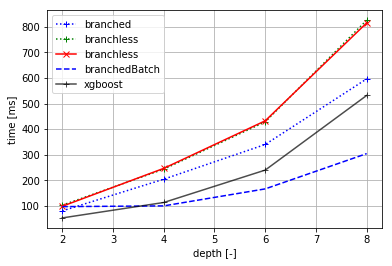

In [8]:
colors = ["blue", "orange", "green", "red","blue", "orange", "green", "red", "k"]
my_labels = ["branched", "branchless", "branchedJIT", "branchlessJIT", "branched", "branchless", "branchedJIT", "branchlessJIT", "xgb"]


colors = ["blue", "green", "red","blue", "green", "k"]
my_labels = ["branched", "branchless", "branchless", "branchedBatch", "branchlessBatch", "xgb"]
linestyles = [":+",":+","-x","--","--,"]

fig_folder = FIG_FOLDER
x_units=" [-]"
y_units=" [ms]"
scaled=False
fname_postfix="_old"
with_error_bars=False
indices=[]
is_xlog=False
is_ylog=False
single_events_indices = [0,1,2,3]
labels=my_labels

fig=plt.figure()

#linestyles = [":+","--,"]
#colors = ["orange", "cyan", "green", "red"]
for i in [0,1,2,3]:
    label = labels[i]
    to_plot = data_dict["mins"][:,i]
    if scaled is True:
        to_plot = to_plot/data_dict["abscisse"]
    plt.plot(data_dict["abscisse"], to_plot,linestyles[i], color=colors[i], label=label )
to_plot = data_dict["mins"][:,len(my_labels)-1]
if scaled is True:
    to_plot = to_plot/data_dict["abscisse"]
plt.plot(data_dict["abscisse"], to_plot,"-+k", label="xgboost", alpha=0.7)
bench_name.find("VS")
y_label = bench_name[:bench_name.find("VS")]
x_label = bench_name[bench_name.find("VS")+2:]

if scaled is True:
    y_label = y_label+"/"+x_label
plt.xlabel(x_label+x_units)
plt.ylabel(y_label+y_units)

plt.grid()

if is_xlog:
    plt.xscale('log')
if is_ylog:
    plt.yscale('log')
#plt.legend(loc=9);
plt.legend();
plt.show()
fig.savefig(fig_folder+bench_name+fname_postfix+".pdf", format="pdf")

# timeVSfeats

Files: ['0_abscisse.npy', 'min_000_.npy', 'min_001_.npy', 'min_002_.npy', 'min_003_.npy', 'min_004_.npy', 'min_005_.npy', 'std_000_.npy', 'std_001_.npy', 'std_002_.npy', 'std_003_.npy', 'std_004_.npy', 'std_005_.npy']
Abscisse shape: (6,)
Mins shape: (6, 11)
Std_dev: (6, 11)


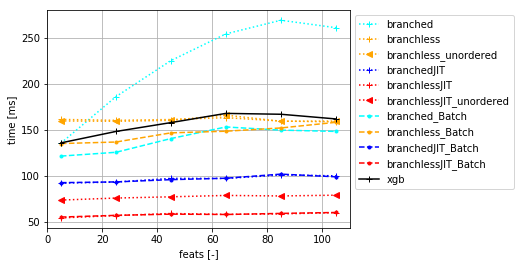

In [9]:
bench_name = "timeVSfeats"

mypath="./"+TMP_FOLDER+bench_name+"/"
data_dict = get_values_from_bench(mypath)

my_labels = ["branched", "branchless", "branchedJIT", "branchlessJIT", "xgb"]
plot_labels(data_dict ,bench_name, FIG_FOLDER, scaled=False, fname_postfix="", indices=[])

# timeVStrees

Files: ['0_abscisse.npy', 'min_000_.npy', 'min_001_.npy', 'min_002_.npy', 'min_003_.npy', 'min_004_.npy', 'std_000_.npy', 'std_001_.npy', 'std_002_.npy', 'std_003_.npy', 'std_004_.npy']
Abscisse shape: (5,)
Mins shape: (5, 11)
Std_dev: (5, 11)


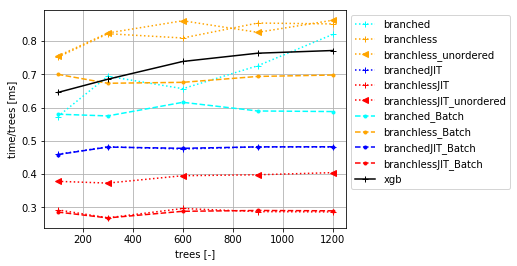

In [10]:
bench_name = "timeVStrees"

# get data
mypath="./"+TMP_FOLDER+bench_name+"/"
data_dict = get_values_from_bench(mypath)

plot_labels(data_dict, bench_name, FIG_FOLDER, scaled=True, fname_postfix="", indices=[])

# timeVSevents

Files: ['0_abscisse.npy', 'min_000_.npy', 'min_001_.npy', 'min_002_.npy', 'min_003_.npy', 'min_004_.npy', 'min_005_.npy', 'std_000_.npy', 'std_001_.npy', 'std_002_.npy', 'std_003_.npy', 'std_004_.npy', 'std_005_.npy']
Abscisse shape: (6,)
Mins shape: (6, 11)
Std_dev: (6, 11)


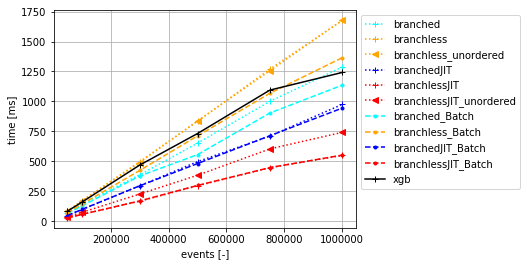

In [11]:
bench_name = "timeVSevents"

mypath="./"+TMP_FOLDER+bench_name+"/"
mypath="./"+"tmp/"+bench_name+"/"
data_dict = get_values_from_bench(mypath)

plot_labels(data_dict, bench_name, FIG_FOLDER, is_xlog=False ,is_ylog=False, 
            scaled=False, fname_postfix="", indices=[]) # ,indices=[1,-1]

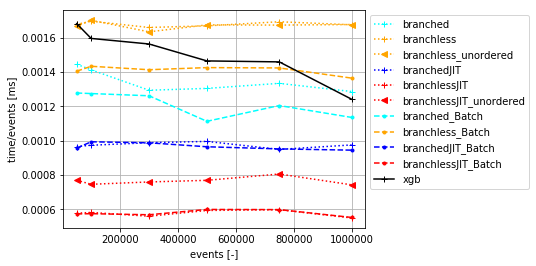

In [12]:
plot_labels(data_dict, bench_name, FIG_FOLDER, is_xlog=False ,is_ylog=False, 
            scaled=True, fname_postfix="_scaled", indices=[]) 

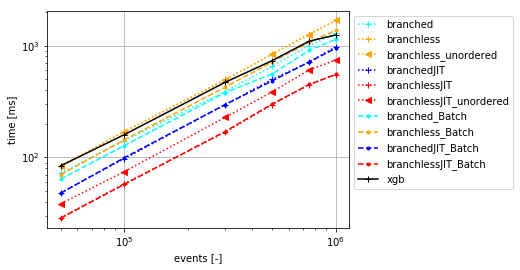

In [13]:
plot_labels(data_dict, bench_name, FIG_FOLDER, is_xlog=True ,is_ylog=True, scaled=False, fname_postfix="_logs")

# timeVSmiddleEvents

Files: ['0_abscisse.npy', 'min_000_.npy', 'min_001_.npy', 'min_002_.npy', 'min_003_.npy', 'min_004_.npy', 'std_000_.npy', 'std_001_.npy', 'std_002_.npy', 'std_003_.npy', 'std_004_.npy']
Abscisse shape: (5,)
Mins shape: (5, 11)
Std_dev: (5, 11)


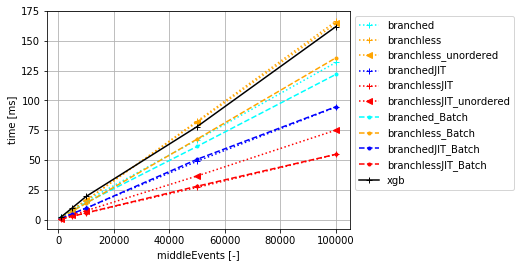

In [14]:
bench_name = "timeVSmiddleEvents"

mypath="./"+TMP_FOLDER+bench_name+"/"
data_dict = get_values_from_bench(mypath)


plot_labels(data_dict, bench_name, FIG_FOLDER, scaled=False, fname_postfix="", indices=[])

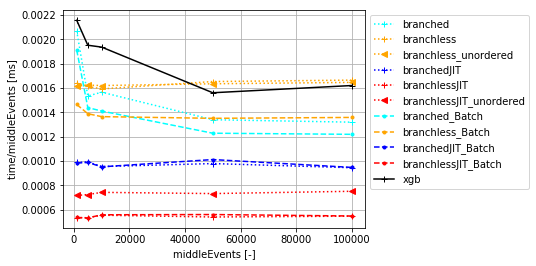

In [15]:
plot_labels(data_dict, bench_name, FIG_FOLDER, scaled=True, fname_postfix="_scaled", indices=[])

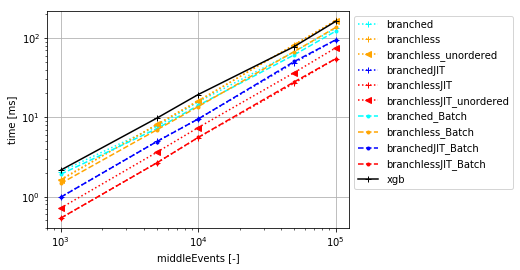

In [16]:
plot_labels(data_dict, bench_name, FIG_FOLDER, is_xlog=True ,is_ylog=True, scaled=False, fname_postfix="_log", indices=[])

# timeVSfewEvents

Files: ['0_abscisse.npy', 'min_000_.npy', 'min_001_.npy', 'min_002_.npy', 'min_003_.npy', 'min_004_.npy', 'min_005_.npy', 'min_006_.npy', 'min_007_.npy', 'min_008_.npy', 'std_000_.npy', 'std_001_.npy', 'std_002_.npy', 'std_003_.npy', 'std_004_.npy', 'std_005_.npy', 'std_006_.npy', 'std_007_.npy', 'std_008_.npy']
Abscisse shape: (9,)
Mins shape: (9, 11)
Std_dev: (9, 11)


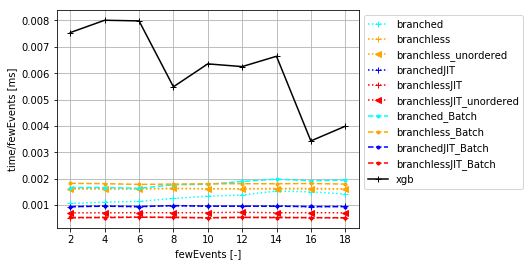

In [17]:
bench_name = "timeVSfewEvents"

mypath="./"+TMP_FOLDER+bench_name+"/"
data_dict = get_values_from_bench(mypath)

plot_labels(data_dict, bench_name, FIG_FOLDER, is_xlog=False ,is_ylog=False, scaled=True, fname_postfix="_scaled")

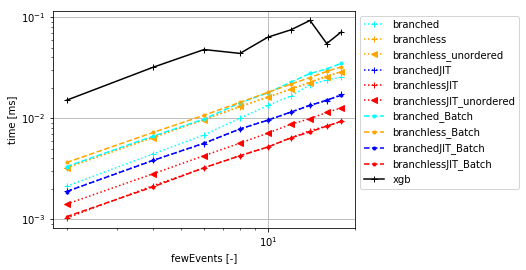

In [18]:
plot_labels(data_dict, bench_name, FIG_FOLDER, is_xlog=True ,is_ylog=True, scaled=False, fname_postfix="_log")

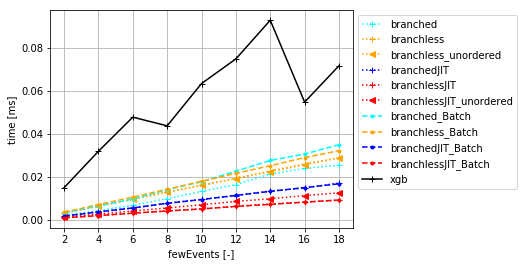

In [19]:
plot_labels(data_dict, bench_name, FIG_FOLDER, scaled=False, fname_postfix="")